In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

print(tf.__version__)
print(K.__version__)

2.4.1
2.4.0


# VQ-VAE
---

This notebook contains a `Keras / tensorflow` implementation of the `VQ-VAE` model, which was introduced in [*Neural Discrete Representation Learning* (van den Oord et al, NeurIPS 2017)](https://arxiv.org/abs/1711.00937). This is a generative model based on Variational Auto Encoders (`VAE`) which aims to make the latent space discrete using Vector Quantization (`VQ`) techniques. This implementation trains a VQ-VAE based on simple convolutional blocks (no auto-regressive decoder), and a `PixelCNN` categorical prior as described in the paper. The current code was tested on MNIST.

**Pros (+):**
  * Simple method and training objective
  * "Proper" Discrete latent space. This is a promising property to model data that is inherently discrete, e.g. text.
  

**Cons (-):**
  * Loses the "easy latent sampling" property from VAEs. Two-stage training required to learn a fitting categorical prior. 
  * The training objective does not correspond to a bound on the log-likelihood anymore.
  
**Possible improvements, as described in the paper:**
  * Learn prior *conditioned on the classes* to even further improve sample generation
  * Use a PixelCNN decoder


# Dataset and Hyperparameters
First we load the dataset (here MNIST). Every image has size 28x28 pixels, 1 color channel (grayscale) and we normalize the color values so that inputs lie in [0., 1.]

In [2]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train[..., None] / 255., y_train), (x_test[..., None] / 255., y_test)
        #return (x_train[..., None], y_train), (x_test[..., None], y_test)

(x_train, y_train), (x_test, y_test) = load_data('input/mnist.npz')
print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)

Train images: (60000, 28, 28, 1)
Train labels: (60000,)


In [3]:
print(type(x_train[0,0,0,0]))
print(x_train.nbytes)
print(x_train.shape)
print(np.array(x_train, None).shape)

<class 'numpy.float64'>
376320000
(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [29]:
# Hyperparameters
NUM_LATENT_K = 2                 # Number of codebook entries
NUM_LATENT_D = 128                 # Dimension of each codebook entries
BETA = 1.0                        # Weight for the commitment loss

INPUT_SHAPE = x_train.shape[1:]
SIZE = None                       # Spatial size of latent embedding
                                  # will be set dynamically in `build_vqvae

VQVAE_BATCH_SIZE = 128            # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 25             # Number of epochs
VQVAE_LEARNING_RATE = 3e-4        # Learning rate
VQVAE_LAYERS = [16, 32]           # Number of filters for each layer in the encoder

PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 35          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block

# Building the generative model

The first step is to build the main VQ-VAE model. It consists of a standard encoder-decoder architecture with convolutional blocks. The main novelty lies in the intermediate **Vector Quantizer** layer (`VQ`) that takes care of building a **discrete** latent space.

More specifically, the encoder, `f` is a fully-convolutional neural network that maps input images to latent codes of size $(w, h, d)$, where $d$ is the dimension of the latent space, and $w \times h$ the size of the final feature map. The output of the encoder is then mapped to the closest entry in a discrete **codebook** of $K$ latent codes, $\mathcal E = \{e_0 \dots e_{K-1} \}$ where $\forall i, e_i \in \mathbb{R}^d$.

\begin{align}
&\textbf{input }x \tag{W x H x C}\\
z_e &= f(x) \tag{w x h x d}\\
z_q^{i, j} &= \arg\min_{e \in \mathcal E} \| z_e^{i, j} - e \|^2
\end{align}

The Vector Quantization process is implemented as the following `Keras` Layer:

In [30]:
class VectorQuantizer(K.layers.Layer):  
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k
    
    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = K.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)
        
    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index
    
    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q

The decoder, $g$, then takes the quantized codes $z_q$ as inputs and generates the output image. Here we consider a simple architecture with transposed convolution blocks, mirroring the encoder architecture:

In [31]:
def encoder_pass(inputs, d, num_layers=[16, 32]):
    x = inputs
    x = tf.cast(x, dtype="float64")
    x = K.layers.experimental.preprocessing.Rescaling(scale=1./255.)(x)
    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='relu', 
                            strides=(2, 2), name="conv{}".format(i + 1))(x)
    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
                          strides=(1, 1), name='z_e')(x)
    return z_e

def decoder_pass(inputs, num_layers=[32, 16]):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(2, 2), padding="SAME", 
                                     activation='relu', name="convT{}".format(i + 1))(y)
    decoded = K.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), 
                                       padding="SAME", activation='sigmoid', name='output')(y)
    return decoded

Once these three building blocks are done, we can build the full `VQ-VAE`. One subtility is how we can estimate gradient through the Vector Quantizer: In fact, the transition from $z_e$ to $z_q$ does not allow to backpropagate gradient due to the argmin function. Instead, the authors propose to use a *straight-through estimator*, that directly copies the gradient received by $z_q$ to $z_e$. 

In [32]:
def build_vqvae(k, d, input_shape=(28, 28, 1), num_layers=[16, 32]):
    ##global SIZE
    ## Encoder
    encoder_inputs = K.layers.Input(shape=input_shape, name='encoder_inputs')
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    SIZE = int(z_e.get_shape()[1])

    ## Vector Quantization
    vector_quantizer = VectorQuantizer(k, name="vector_quantizer")
    codebook_indices = vector_quantizer(z_e)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')

    ## Decoder
    decoder_inputs = K.layers.Input(shape=(SIZE, SIZE, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
    
    ## VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
    z_q = sampling_layer(codebook_indices)
    codes = tf.stack([z_e, z_q], axis=-1)
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
    straight_through_zq = straight_through([z_q, z_e])
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')
    
    ## VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZE, SIZE), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler')
    
    ## Transition from codebook indices to model (for training the prior later)
    indices = K.layers.Input(shape=(SIZE, SIZE), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler")
    
    ## Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook')
    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook
    
    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook, SIZE

vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook, SIZE = build_vqvae(
    NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae.summary()

The following Variables were used a Lambda layer's call (sample_from_codebook), but
are not present in its tracked objects:
  <tf.Variable 'vector_quantizer/Variable:0' shape=(2, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
tf.cast_3 (TFOpLambda)          (None, 28, 28, 1)    0           encoder_inputs[0][0]             
_____________________________________________________________________________________________

# Training the VQ-VAE

All is left now is to train the model: The training objective contains the **reconstruction loss** (here, we use mean squared error), the KL divergence term on the latent codebook (ignored because it is constant as we assume a uniform prior during training), and two **vector quantization losses** which guarantee that **(i)** the outputs of the encoder stay close to the codebook entries they are matched to and **(ii)** that the codebook does not grow too much relatively to the space of the encoder outputs.

\begin{align}
\mathcal L_{\text{VQ-VAE}}(x) = - \mathbb{E}_{z \sim f(x)}{p(x | z)} + \| z_e - \bar{z_q}\|^2 + \|\bar{z_e} - z_q\|^2
\end{align}

where $\bar{\cdot}$ denotes the stop gradient operation: i.e., during forward pass, this corresponds to the identity, but during backpropagation no gradients are flowing through this operation. 


In [33]:
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss    



Additionally to the losses, we're also going to monitor the $L2$ norms of the encoded vectors (both output by the encoder and after quantization), represented as `Keras` metrics here.

In [34]:
def zq_norm(y_true, y_pred):
    del y_true
    _, z_q = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_q, axis=-1))

def ze_norm(y_true, y_pred):
    del y_true
    z_e, _ = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_e, axis=-1))

In [35]:
%%time
## Compile and train

vq_vae.compile(loss=[mse_loss, latent_loss], metrics={"latent_codes": [zq_norm, ze_norm]}, optimizer= K.optimizers.Adam(VQVAE_LEARNING_RATE))
history = vq_vae.fit(x_train, x_train, epochs=VQVAE_NUM_EPOCHS, batch_size=VQVAE_BATCH_SIZE, verbose=2)

Epoch 1/25
469/469 - 5s - loss: 0.2839 - decoder_loss: 0.0904 - latent_codes_loss: 0.1935 - latent_codes_zq_norm: 0.5575 - latent_codes_ze_norm: 0.4310
Epoch 2/25
469/469 - 3s - loss: 0.0968 - decoder_loss: 0.0806 - latent_codes_loss: 0.0162 - latent_codes_zq_norm: 0.5501 - latent_codes_ze_norm: 0.5403
Epoch 3/25
469/469 - 3s - loss: 0.0887 - decoder_loss: 0.0806 - latent_codes_loss: 0.0082 - latent_codes_zq_norm: 0.5540 - latent_codes_ze_norm: 0.5559
Epoch 4/25
469/469 - 3s - loss: 0.0972 - decoder_loss: 0.0806 - latent_codes_loss: 0.0166 - latent_codes_zq_norm: 0.5654 - latent_codes_ze_norm: 0.5679
Epoch 5/25
469/469 - 3s - loss: 0.1105 - decoder_loss: 0.0806 - latent_codes_loss: 0.0300 - latent_codes_zq_norm: 0.5789 - latent_codes_ze_norm: 0.5819
Epoch 6/25
469/469 - 3s - loss: 0.1235 - decoder_loss: 0.0805 - latent_codes_loss: 0.0430 - latent_codes_zq_norm: 0.5899 - latent_codes_ze_norm: 0.5940
Epoch 7/25
469/469 - 3s - loss: 0.1424 - decoder_loss: 0.0806 - latent_codes_loss: 0.061

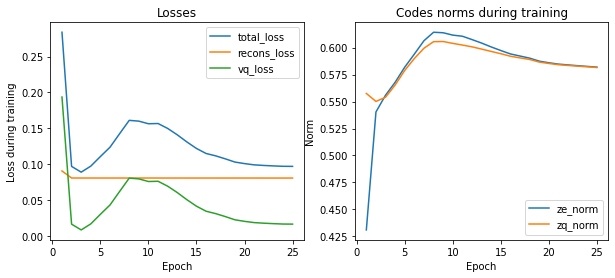

In [36]:
num_epochs = range(1, len(history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, history.history["loss"], label="total_loss")
plt.plot(num_epochs, history.history["decoder_loss"], label="recons_loss")
plt.plot(num_epochs, history.history["latent_codes_loss"], label="vq_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss during training")
plt.legend()
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, history.history["latent_codes_ze_norm"], label="ze_norm")
plt.plot(num_epochs, history.history["latent_codes_zq_norm"], label="zq_norm")
plt.xlabel("Epoch")
plt.ylabel("Norm")
plt.title("Codes norms during training")
plt.legend()
plt.show()

Once training is done, we can also visualize some of the results, such as reconstructions on the test set and the learned codebook entries (projected to 2D with `TSNE`). In particular, we observe that reconstructions are close to perfect, which indicates the model is able to learn a meaningful codebook, as well as how to map images to this discrete space.

Originals versus reconstructions


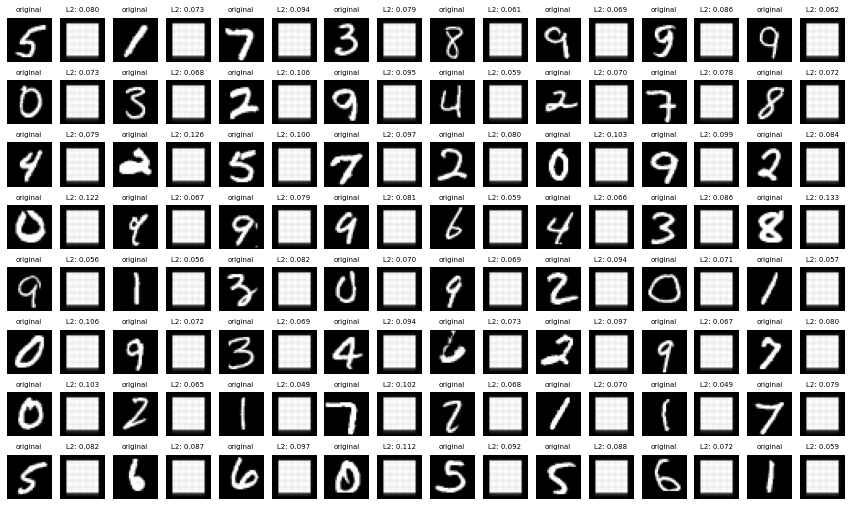

In [37]:
# original versus reconstructions
def recons(model, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    recons, _ = model.predict(x)
    dists = np.mean((recons - x)**2, axis=(1, 2, 3))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i, :, :, 0], cmap='gray')
        plt.title("original", fontsize=7)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i, :, :, 0], cmap='gray')
        plt.title("L2: {:.3f}".format(dists[i]), fontsize=7)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
recons(vq_vae, x_test, 8, 8)

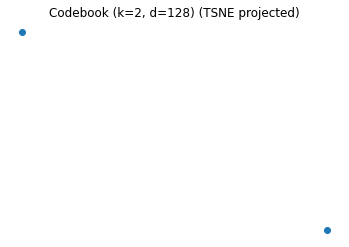

In [38]:
from sklearn.manifold import TSNE
codebook = get_vq_vae_codebook()
codebook = TSNE(2).fit_transform(codebook)
plt.title("Codebook (k={}, d={}) (TSNE projected)".format(NUM_LATENT_K, NUM_LATENT_D))
plt.scatter(codebook[:, 0], codebook[:, 1])
plt.axis('off')
plt.show()

# Learning a prior over the latent space
---
We have now learned an encoder-decoder architecture and a discrete latent codebook powerful enough to encode and reconstruct our dataset. However, the **uniform prior** assumption during training is not sufficient for generating good samples. In fact, due to the fully-convolutional architecture, each image is encoded with `SIZE` x `SIZE` latent vectors from the codebook (for instance, `SIZE = 7` for our current model).

However, the codes for our dataset have no guarantee to lie uniformly on that space, as we assumed during training, but rather have some specific structure that follow a certain non-uniform categorical prior. This can be seen easily by generating images from code feature maps sampled uniformly from the total latent space of size `SIZE` x `SIZE` x $K$.

Images generated under a uniform prior (training assumption)


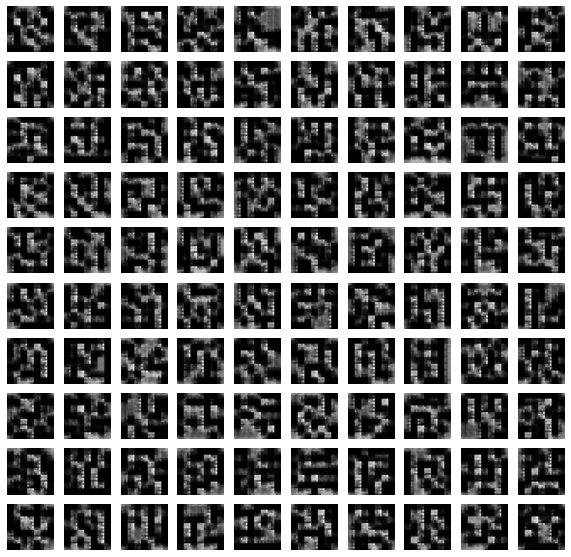

In [39]:
def generate_from_random(sampler, k, size, n_row, n_col):
    n = n_col * n_row
    indices = np.random.randint(0, k, size=(n, size, size))
    generated = sampler.predict(indices, steps=1)
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
print("Images generated under a uniform prior (training assumption)")
generate_from_random(vq_vae_sampler, NUM_LATENT_K, SIZE, 10, 10)

To solve the problem and sample likely codes from the latent space, the authors propose to learn a **powerful categorical prior** over the latent codes from the training images using a `PixelCNN`. PixelCNN is a fully probabilistic autoregressive generative model that generates images (or here, feature maps) pixel by pixel, conditioned on the previously generated pixels. The main drawback of such models is that the sampling process is rather slow. 
However, since here we are only generating small `SIZE` x `SIZE` maps, the overhead is not too bad.

Here we consider the architecture proposed in [*Conditional Image Generation with PixelCNN Decoders* (van den Oord et al, NeurIPS 2017)](https://arxiv.org/abs/1606.05328) which uses **gated** and **masked** convolutions to model the fact that pixels only depend from the previously generated context. We implement the base building block of the architecture as the following `Keras` pipeline:

In [41]:
# References:
# https://github.com/anantzoid/Conditional-PixelCNN-decoder/blob/master/layers.py
# https://github.com/ritheshkumar95/pytorch-vqvae

def gate(inputs):
    """Gated activations"""
    x, y = tf.split(inputs, 2, axis=-1)
    return Kb.tanh(x) * Kb.sigmoid(y)


class MaskedConv2D(K.layers.Layer):
    """Masked convolution"""
    def __init__(self, kernel_size, out_dim, direction, mode, **kwargs):
        self.direction = direction     # Horizontal or vertical
        self.mode = mode               # Mask type "a" or "b"
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        super(MaskedConv2D, self).__init__(**kwargs)
    
    def build(self, input_shape):   
        filter_mid_y = self.kernel_size[0] // 2
        filter_mid_x = self.kernel_size[1] // 2        
        in_dim = int(input_shape[-1])
        w_shape = [self.kernel_size[0], self.kernel_size[1], in_dim, self.out_dim]
        mask_filter = np.ones(w_shape, dtype=np.float32)
        # Build the mask
        if self.direction == "h":
            mask_filter[filter_mid_y + 1:, :, :, :] = 0.
            mask_filter[filter_mid_y, filter_mid_x + 1:, :, :] = 0.
        elif self.direction == "v":
            if self.mode == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.
            elif self.mode == 'b':
                mask_filter[filter_mid_y+1:, :, :, :] = 0.0
        if self.mode == 'a':
            mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        # Create convolution layer parameters with masked kernel
        self.W = mask_filter * self.add_weight("W_{}".format(self.direction), w_shape, trainable=True)
        self.b = self.add_weight("v_b", [self.out_dim,], trainable=True)
    
    def call(self, inputs):
        return K.backend.conv2d(inputs, self.W, strides=(1, 1)) + self.b

    
def gated_masked_conv2d(v_stack_in, h_stack_in, out_dim, kernel, mask='b', residual=True, i=0):
    """Basic Gated-PixelCNN block. 
       This is an improvement over PixelRNN to avoid "blind spots", i.e. pixels missingt from the
       field of view. It works by having two parallel stacks, for the vertical and horizontal direction, 
       each being masked  to only see the appropriate context pixels.
    """
    kernel_size = (kernel // 2 + 1, kernel)
    padding = (kernel // 2, kernel // 2)
        
    v_stack = K.layers.ZeroPadding2D(padding=padding, name="v_pad_{}".format(i))(v_stack_in)
    v_stack = MaskedConv2D(kernel_size, out_dim * 2, "v", mask, name="v_masked_conv_{}".format(i))(v_stack)
    v_stack = v_stack[:, :int(v_stack_in.get_shape()[-3]), :, :]
    v_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="v_gate_{}".format(i))(v_stack)
    
    kernel_size = (1, kernel // 2 + 1)
    padding = (0, kernel // 2)
    h_stack = K.layers.ZeroPadding2D(padding=padding, name="h_pad_{}".format(i))(h_stack_in)
    h_stack = MaskedConv2D(kernel_size, out_dim * 2, "h", mask, name="h_masked_conv_{}".format(i))(h_stack)
    h_stack = h_stack[:, :, :int(h_stack_in.get_shape()[-2]), :]
    h_stack_1 = K.layers.Conv2D(filters=out_dim * 2, kernel_size=1, strides=(1, 1), name="v_to_h_{}".format(i))(v_stack)
    h_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="h_gate_{}".format(i))(h_stack + h_stack_1)
    
    h_stack_out =  K.layers.Conv2D(filters=out_dim, kernel_size=1, strides=(1, 1), name="res_conv_{}".format(i))(h_stack_out)
    if residual:
        h_stack_out += h_stack_in
    return v_stack_out, h_stack_out

# Prior training data

In order to train the prior, we're going to encode every training image to obtain their discrete representation as indices in the latent codebook. This is also a good opportunity to **visualize the discrete representations learned by the encoder**. Here we can notice some interesting features, such as: all the black/background pixels are mapped to the same codeword, and the same for dense/white pixels (e.g., the ones at the center of a number)

In [42]:
# Dataset to train the Prior
z_train = encoder.predict(x_train)
z_train.shape

(60000, 7, 7)

Images encoded as discrete codes


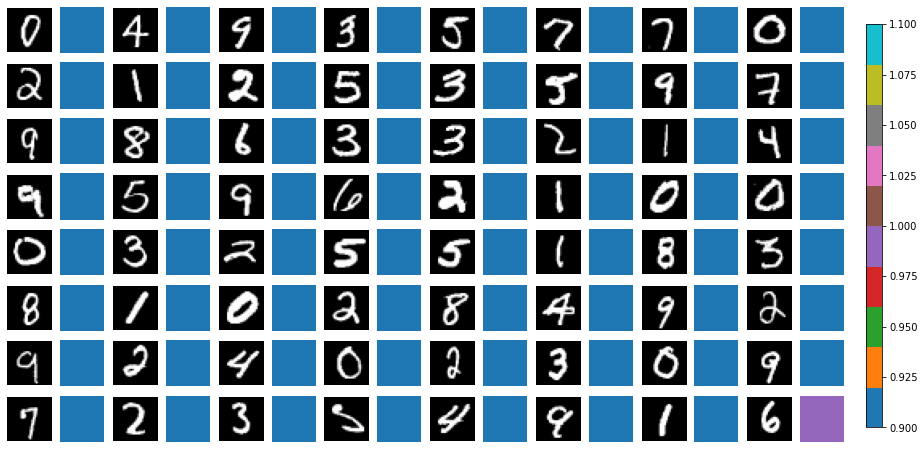

In [43]:
# original versus reconstructions
def viz_codes(encoder, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    codes = encoder.predict(x)
    fig = plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2*i+1)
        plt.imshow(x[i,:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2*i+2)
        plt.pcolor(codes[i, ::-1, :], cmap='tab10') #flip y-axis origin to match imshow
        plt.axis('off')
    cbaxes = fig.add_axes([0.92, 0.15, 0.015, 0.7]) 
    cb = plt.colorbar(cax=cbaxes)  
    plt.show()
    
    
print("Images encoded as discrete codes")
viz_codes(encoder, x_test, 8, 8)

Equipped with the Masked gated convolutions and the training set, we can finally build our PixelCNN architecture and train the prior. The full model simply consists in a concatenation of masked and gated convolutions, followed by two fully-connected layers to output the final prediction. Here the training objective is a multi-class classification one, as the prior should output a map of codebook **indices**.

In [44]:
def build_pixelcnn(codes_sampler, k, size, num_layers, num_feature_maps=32):
    pixelcnn_prior_inputs = K.layers.Input(shape=(size, size), name='pixelcnn_prior_inputs', dtype=tf.int32)
    z_q = codes_sampler(pixelcnn_prior_inputs) # maps indices to the actual codebook
    
    v_stack_in, h_stack_in = z_q, z_q
    for i in range(num_layers):
        mask = 'b' if i > 0 else 'a'
        kernel_size = 3 if i > 0 else 7
        residual = True if i > 0 else False
        v_stack_in, h_stack_in = gated_masked_conv2d(v_stack_in, h_stack_in, num_feature_maps,
                                                     kernel=kernel_size, residual=residual, i=i + 1)

    fc1 = K.layers.Conv2D(filters=num_feature_maps, kernel_size=1, name="fc1")(h_stack_in)
    fc2 = K.layers.Conv2D(filters=k, kernel_size=1, name="fc2")(fc1) 
    # outputs logits for probabilities of codebook indices for each cell

    pixelcnn_prior = K.Model(inputs=pixelcnn_prior_inputs, outputs=fc2, name='pixelcnn-prior')

    # Distribution to sample from the pixelcnn
    dist = tfp.distributions.Categorical(logits=fc2)
    sampled = dist.sample()
    prior_sampler = K.Model(inputs=pixelcnn_prior_inputs, outputs=sampled, name='pixelcnn-prior-sampler')
    return pixelcnn_prior, prior_sampler

pixelcnn_prior, prior_sampler = build_pixelcnn(codes_sampler, NUM_LATENT_K, SIZE, 
                                               PIXELCNN_NUM_BLOCKS, PIXELCNN_NUM_FEATURE_MAPS)
#pixelcnn_prior.summary()

In [ ]:
pixelcnn_prior.summary()

# Training and Testing the prior

In [ ]:
%%time
# Train the PixelCNN and monitor prediction accuracy
def accuracy(y_true, y_pred):
    size = int(y_pred.get_shape()[-2])
    k = int(y_pred.get_shape()[-1])
    y_true = tf.reshape(y_true, (-1, size * size))
    y_pred = tf.reshape(y_pred, (-1, size * size, k))
    return Kb.cast(Kb.equal(y_true, Kb.cast(Kb.argmax(y_pred, axis=-1), Kb.floatx())), Kb.floatx())

pixelcnn_prior.compile(loss=K.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[accuracy],
                       optimizer=K.optimizers.Adam(PIXELCNN_LEARNING_RATE))

prior_history = pixelcnn_prior.fit(z_train, z_train, epochs=PIXELCNN_NUM_EPOCHS, 
                                   batch_size=PIXELCNN_BATCH_SIZE, verbose=1)

In [ ]:
num_epochs = range(1, len(prior_history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, prior_history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, prior_history.history["accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training")
plt.show()

Once again, we can check the model ability to **reconstruct** discrete latent codes obtained from the test set:

In [ ]:
def recons_prior(model, z, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(z.shape[0], size=n, replace=False)
        x = z[x]
    else:
        x = z[:n]
    recons = model.predict(x)
    recons = np.argmax(recons, axis=-1)
    accs = np.mean(np.equal(recons, x), axis=(1, 2))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i], cmap='tab10')
        plt.title("original", fontsize=8)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i], cmap='tab10')
        plt.title("acc: {:.3f}".format(accs[i]), fontsize=8)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
z_test = encoder.predict(x_test)
recons_prior(pixelcnn_prior, z_test, 8, 8)

More importantly, let's have a look at images generated by sampling from the prior. As expected, they look much better than sampling from a uniform distribution, which means that **(i)** discrete codes for our image distribution lie in a specific subset of the latent space and **(ii)** the PixelCNN was able to properly model a prior probability distribution on that space

In [ ]:
def sample_from_prior(prior, shape):
    """sample from the PixelCNN prior, pixel by pixel"""
    global prior_sampler
    X = np.zeros(shape, dtype=np.int32)
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            sampled = prior_sampler.predict(X)
            X[:, i, j] = sampled[:, i, j]
    return X
            
    
def generate(prior, codes_sampler, size, n_row, n_col):
    """Generate random images by sampling codes from the given prior"""
    n = n_col * n_row
    indices = sample_from_prior(prior, (n, size, size))
    zq = codes_sampler(indices)
    generated = decoder.predict(zq, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(indices[i], cmap='tab10')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
print("Random codes sampled from the prior and correspopnding decoded images")
generate(prior_sampler, codes_sampler, SIZE, 10, 10)